In [1]:
import Load_Downsize_SaveAsH5 as cvt

import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


### partial data with Top as target

In [2]:
filePath = './ourdata/'
features = ['j_index','j1_phirel','j1_etarel','j1_phirot','j1_etarot','j1_deltaR','j1_pdgid','j1_pt','j1_ptrel','j1_erel'] 
labels = ['j_g','j_q','j_w','j_z','j_t']
#ratio=[.25,.25,.25,.25,1]
size=4000
seed=42


In [3]:
cvt.LoadTransSave(filePath,features, labels,size=size,seed=seed)

### prepare data

In [4]:
cols = dict(zip(features+['constituents_index'], [i for i in range(len(features)+1)]))

features_list = ['j1_ptrel','j1_etarot','j1_phirot','j1_phirel','j1_etarel','j1_erel','j1_deltaR','j1_pdgid']

def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[],'label':[]}
    f = h5py.File(h5path,'r')
        
    raw_data = np.array([f[col][()] for col in cols])
    label_arr = f['label'][()]
    raw_data = raw_data.transpose((1,0))
    
    mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2)) # prepare constituents list
    for i in range(len(raw_data)):
        cIndex = int(raw_data[i][cols['constituents_index']])
        if cIndex >= 100:                                               # skip when excess 100 particles
            continue
        
        mask[cIndex] = [1]  # no mask for now
            
        points[cIndex] = np.array([raw_data[i][cols['j1_etarel']],raw_data[i][cols['j1_phirel']]])
        features[cIndex] = np.array([raw_data[i][cols[feat]] for feat in features_list])
                
        if i < len(raw_data)-1:
            if raw_data[i][cols['j_index']] != raw_data[i+1][cols['j_index']] : # save the jet before switch to another
                Data['mask'].append(mask)
                Data['points'].append(points)
                Data['features'].append(features)
                Data['label'].append(label_arr[i])
                mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2))  
    f.close()
    y = Data.pop('label')
    return Data, y

def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total

def separatedata(Data,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = Data["mask"]
    features = Data["features"]
    points = Data["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test)

In [5]:
h5Path = "ourdata/data_4000jets_5labels.h5"
Data,y = h5_to_data(h5Path)
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

check shape:  (100, 1) (100, 2) (100, 8)


In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(Data,y,0.25,0.25)

In [7]:
import sys
sys.path.insert(0,'models')
from tf_keras_model import get_particle_net_lite, get_particle_net

In [8]:
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}
num_classes = 5
model = get_particle_net_lite(num_classes, input_shapes)

In [9]:
batch_size = 1024
epochs = 400

In [10]:
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 100, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 100, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 100, 1)]     0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [11]:
history = model.fit(X_train ,y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True)
model.evaluate(X_test,  y_test, verbose=2)

Train on 8546 samples, validate on 4273 samples
Epoch 1/400
8546/8546 [==============================] - 12s 1ms/sample - loss: 1.6350 - accuracy: 0.1852 - val_loss: 1.5960 - val_accuracy: 0.2003
Epoch 2/400
8546/8546 [==============================] - 7s 811us/sample - loss: 1.6027 - accuracy: 0.1972 - val_loss: 1.5976 - val_accuracy: 0.1956
Epoch 3/400
8546/8546 [==============================] - 7s 797us/sample - loss: 1.5799 - accuracy: 0.2146 - val_loss: 1.5993 - val_accuracy: 0.1736
Epoch 4/400
8546/8546 [==============================] - 7s 821us/sample - loss: 1.5627 - accuracy: 0.2410 - val_loss: 1.6008 - val_accuracy: 0.2130
Epoch 5/400
8546/8546 [==============================] - 7s 844us/sample - loss: 1.5429 - accuracy: 0.2765 - val_loss: 1.6019 - val_accuracy: 0.2495
Epoch 6/400
8546/8546 [==============================] - 7s 828us/sample - loss: 1.5289 - accuracy: 0.2989 - val_loss: 1.6029 - val_accuracy: 0.2567
Epoch 7/400
8546/8546 [==============================] - 7s

8546/8546 [==============================] - 7s 812us/sample - loss: 1.0102 - accuracy: 0.6053 - val_loss: 1.1261 - val_accuracy: 0.5341
Epoch 56/400
8546/8546 [==============================] - 7s 815us/sample - loss: 1.0071 - accuracy: 0.6043 - val_loss: 1.1131 - val_accuracy: 0.5401
Epoch 57/400
8546/8546 [==============================] - 7s 813us/sample - loss: 1.0063 - accuracy: 0.6000 - val_loss: 1.1007 - val_accuracy: 0.5479
Epoch 58/400
8546/8546 [==============================] - 7s 794us/sample - loss: 0.9981 - accuracy: 0.6058 - val_loss: 1.0920 - val_accuracy: 0.5607
Epoch 59/400
8546/8546 [==============================] - 7s 834us/sample - loss: 0.9974 - accuracy: 0.6068 - val_loss: 1.0788 - val_accuracy: 0.5710
Epoch 60/400
8546/8546 [==============================] - 7s 813us/sample - loss: 0.9938 - accuracy: 0.6091 - val_loss: 1.0725 - val_accuracy: 0.5710
Epoch 61/400
8546/8546 [==============================] - 7s 813us/sample - loss: 0.9914 - accuracy: 0.6134 - val

8546/8546 [==============================] - 7s 811us/sample - loss: 0.8943 - accuracy: 0.6655 - val_loss: 0.9018 - val_accuracy: 0.6635
Epoch 110/400
8546/8546 [==============================] - 7s 797us/sample - loss: 0.8952 - accuracy: 0.6665 - val_loss: 0.9009 - val_accuracy: 0.6660
Epoch 111/400
8546/8546 [==============================] - 7s 798us/sample - loss: 0.8922 - accuracy: 0.6660 - val_loss: 0.8998 - val_accuracy: 0.6660
Epoch 112/400
8546/8546 [==============================] - 7s 795us/sample - loss: 0.8904 - accuracy: 0.6713 - val_loss: 0.8987 - val_accuracy: 0.6653
Epoch 113/400
8546/8546 [==============================] - 7s 813us/sample - loss: 0.8895 - accuracy: 0.6696 - val_loss: 0.8974 - val_accuracy: 0.6672
Epoch 114/400
8546/8546 [==============================] - 7s 813us/sample - loss: 0.8875 - accuracy: 0.6681 - val_loss: 0.8975 - val_accuracy: 0.6635
Epoch 115/400
8546/8546 [==============================] - 7s 815us/sample - loss: 0.8865 - accuracy: 0.6707

8546/8546 [==============================] - 7s 828us/sample - loss: 0.8345 - accuracy: 0.6971 - val_loss: 0.8606 - val_accuracy: 0.6859
Epoch 164/400
8546/8546 [==============================] - 7s 830us/sample - loss: 0.8351 - accuracy: 0.7013 - val_loss: 0.8599 - val_accuracy: 0.6904
Epoch 165/400
8546/8546 [==============================] - 7s 828us/sample - loss: 0.8310 - accuracy: 0.7017 - val_loss: 0.8601 - val_accuracy: 0.6831
Epoch 166/400
8546/8546 [==============================] - 7s 829us/sample - loss: 0.8359 - accuracy: 0.6946 - val_loss: 0.8587 - val_accuracy: 0.6908
Epoch 167/400
8546/8546 [==============================] - 7s 832us/sample - loss: 0.8292 - accuracy: 0.7034 - val_loss: 0.8598 - val_accuracy: 0.6883
Epoch 168/400
8546/8546 [==============================] - 7s 827us/sample - loss: 0.8290 - accuracy: 0.7029 - val_loss: 0.8589 - val_accuracy: 0.6885
Epoch 169/400
8546/8546 [==============================] - 7s 832us/sample - loss: 0.8284 - accuracy: 0.7003

8546/8546 [==============================] - 7s 830us/sample - loss: 0.7921 - accuracy: 0.7185 - val_loss: 0.8331 - val_accuracy: 0.7049
Epoch 218/400
8546/8546 [==============================] - 7s 829us/sample - loss: 0.7868 - accuracy: 0.7231 - val_loss: 0.8319 - val_accuracy: 0.7054
Epoch 219/400
8546/8546 [==============================] - 7s 831us/sample - loss: 0.7869 - accuracy: 0.7217 - val_loss: 0.8320 - val_accuracy: 0.7061
Epoch 220/400
8546/8546 [==============================] - 7s 831us/sample - loss: 0.7828 - accuracy: 0.7270 - val_loss: 0.8306 - val_accuracy: 0.7086
Epoch 221/400
8546/8546 [==============================] - 7s 833us/sample - loss: 0.7798 - accuracy: 0.7270 - val_loss: 0.8318 - val_accuracy: 0.7068
Epoch 222/400
8546/8546 [==============================] - 7s 829us/sample - loss: 0.7840 - accuracy: 0.7189 - val_loss: 0.8317 - val_accuracy: 0.7086
Epoch 223/400
8546/8546 [==============================] - 7s 829us/sample - loss: 0.7863 - accuracy: 0.7217

8546/8546 [==============================] - 7s 830us/sample - loss: 0.7538 - accuracy: 0.7354 - val_loss: 0.8171 - val_accuracy: 0.7124
Epoch 272/400
8546/8546 [==============================] - 7s 828us/sample - loss: 0.7519 - accuracy: 0.7354 - val_loss: 0.8142 - val_accuracy: 0.7147
Epoch 273/400
8546/8546 [==============================] - 7s 828us/sample - loss: 0.7507 - accuracy: 0.7347 - val_loss: 0.8149 - val_accuracy: 0.7131
Epoch 274/400
8546/8546 [==============================] - 7s 829us/sample - loss: 0.7489 - accuracy: 0.7311 - val_loss: 0.8150 - val_accuracy: 0.7136
Epoch 275/400
8546/8546 [==============================] - 7s 829us/sample - loss: 0.7521 - accuracy: 0.7380 - val_loss: 0.8144 - val_accuracy: 0.7145
Epoch 276/400
8546/8546 [==============================] - 7s 830us/sample - loss: 0.7522 - accuracy: 0.7363 - val_loss: 0.8126 - val_accuracy: 0.7166
Epoch 277/400
8546/8546 [==============================] - 7s 829us/sample - loss: 0.7474 - accuracy: 0.7355

8546/8546 [==============================] - 7s 830us/sample - loss: 0.7246 - accuracy: 0.7460 - val_loss: 0.8031 - val_accuracy: 0.7227
Epoch 326/400
8546/8546 [==============================] - 7s 814us/sample - loss: 0.7220 - accuracy: 0.7480 - val_loss: 0.8043 - val_accuracy: 0.7224
Epoch 327/400
8546/8546 [==============================] - 7s 794us/sample - loss: 0.7248 - accuracy: 0.7485 - val_loss: 0.8040 - val_accuracy: 0.7192
Epoch 328/400
8546/8546 [==============================] - 7s 824us/sample - loss: 0.7190 - accuracy: 0.7494 - val_loss: 0.8024 - val_accuracy: 0.7208
Epoch 329/400
8546/8546 [==============================] - 7s 793us/sample - loss: 0.7214 - accuracy: 0.7460 - val_loss: 0.8025 - val_accuracy: 0.7222
Epoch 330/400
8546/8546 [==============================] - 7s 795us/sample - loss: 0.7257 - accuracy: 0.7443 - val_loss: 0.8033 - val_accuracy: 0.7215
Epoch 331/400
8546/8546 [==============================] - 7s 806us/sample - loss: 0.7207 - accuracy: 0.7496

8546/8546 [==============================] - 7s 863us/sample - loss: 0.6990 - accuracy: 0.7561 - val_loss: 0.7980 - val_accuracy: 0.7224
Epoch 380/400
8546/8546 [==============================] - 7s 864us/sample - loss: 0.6985 - accuracy: 0.7581 - val_loss: 0.7970 - val_accuracy: 0.7231
Epoch 381/400
8546/8546 [==============================] - 8s 880us/sample - loss: 0.6952 - accuracy: 0.7560 - val_loss: 0.7978 - val_accuracy: 0.7224
Epoch 382/400
8546/8546 [==============================] - 7s 871us/sample - loss: 0.6987 - accuracy: 0.7538 - val_loss: 0.7980 - val_accuracy: 0.7229
Epoch 383/400
8546/8546 [==============================] - 7s 859us/sample - loss: 0.7012 - accuracy: 0.7538 - val_loss: 0.7985 - val_accuracy: 0.7234
Epoch 384/400
8546/8546 [==============================] - 7s 863us/sample - loss: 0.6986 - accuracy: 0.7557 - val_loss: 0.7975 - val_accuracy: 0.7229
Epoch 385/400
8546/8546 [==============================] - 7s 864us/sample - loss: 0.6971 - accuracy: 0.7543

[0.8249226589039993, 0.70145065]

Text(0.25, 0.9, 'Particle_lite')

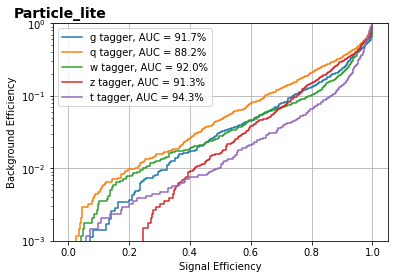

In [12]:
predict_test = model.predict(X_test)
predict_test = predict_test.transpose((1,0))
y_test = y_test.transpose((1,0))
labels = ['g','q','w','z','t']
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[i]
    df[label + '_pred'] = predict_test[i]
    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
    auc1[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend(loc='upper left')
plt.ylim(0.001,1)
plt.grid(True)

plt.figtext(0.25, 0.90,'Particle_lite',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

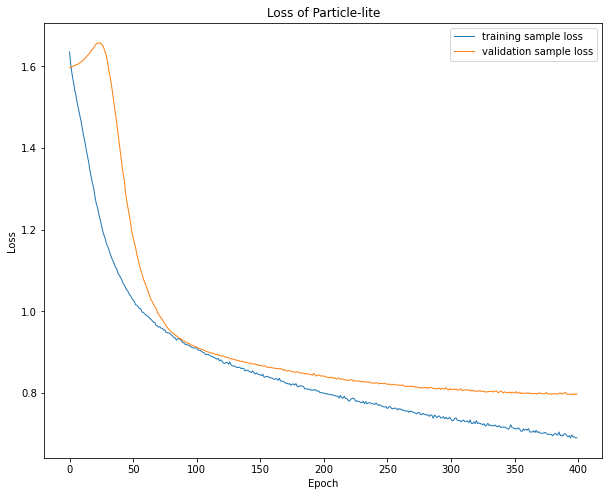

In [13]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Loss of Particle-lite')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
plt.show()
plt.close()

In [14]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'particle net ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

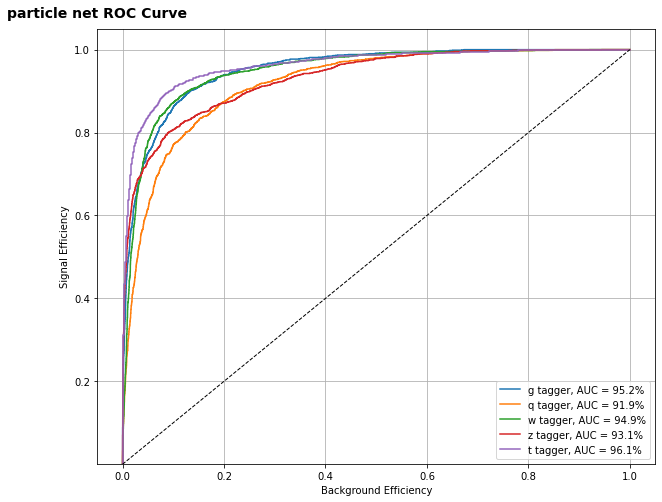

In [15]:
y_pred = makeRoc(X_train, y_train,labels, model, outputSuffix='particle net')